# Project 2 Model Predictive Control

## Linear Dynamics

In this tutorial, we will continue to use the rocket landing case with the same dynamics. 

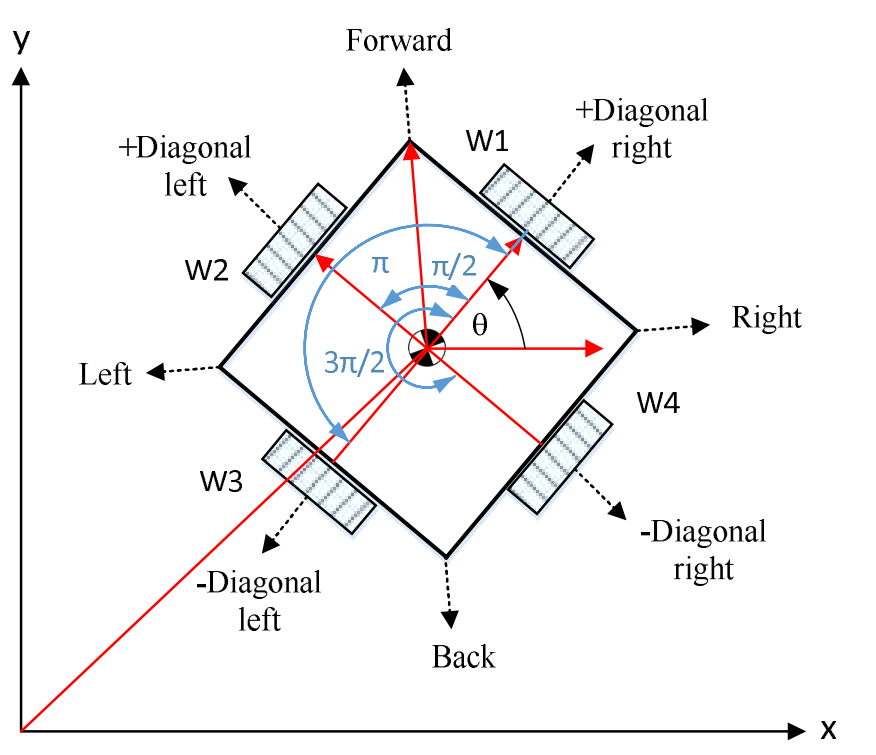

Recall that the dynamics of the rocket 

$\textbf{x}(t+1)=f(\textbf{x}(t),u(t))$ is:

$$
\begin{aligned}
& \dot{x}(t) = \frac{rwheel}{2}*(-\sin(\theta+\pi/4)*\omega_{1}(t)-\sin(\theta+3\pi/4)*\omega_{2}(t)-\sin(\theta+5\pi/4)*\omega_{3}(t)-\sin(\theta+7\pi/4)*\omega_{4}(t)) \\
& \dot{y}(t) = \frac{rwheel}{2}*(\cos(\theta+\pi/4)*\omega_{1}(t)+\cos(\theta+3\pi/4)*\omega_{2}(t)+\cos(\theta+5\pi/4)*\omega_{3}(t)+\cos(\theta+7\pi/4)*\omega_{4}(t)) \\
& \dot{\theta}(t) = \frac{rwheel}{2}*(\frac{1}{2*rRobot}*\omega_{1}(t)+\frac{1}{2*rRobot}*\omega_{2}(t)+\frac{1}{2*rRobot}*\omega_{3}(t)+\frac{1}{2*rRobot}*\omega_{4}(t)), \\
& x(t+1) = x(t) + \dot{x}(t) \Delta t, \\
& y(t+1) = y(t) + \dot{y}(t) \Delta t, \\
& \theta(t+1) = \theta(t) + \dot{\theta}(t) \Delta t
& \end{aligned}
$$

where the rocket state $\textbf{x}(t)$ is represented by its coordinates $x(t)$ and $y(t)$, velocity $\dot{x}(t)$, $\dot{y}(t)$, and orientation $\theta(t)$, i.e., $\textbf{x}(t) = [\dot{x}(t), \dot{y}(t), \dot{\theta}(t), x(t), y(t), \theta(t)]^T$, and $t$ specifies time. The control input $\textbf{u}(t)$ of the rocket includes thrust $a(t)$ and angular velocity $\omega(t)$. $\Delta t$ is a time interval. $g$ is the gravity.

The key step in MPC is to use linearized dynamics. To do so, we use Taylor's expansion of the dynamics $f(\textbf{x},u(t))$ at the current state $\textbf{x}_0$ and zero control input:

$$
A = \nabla_x f = \left[\begin{array}{llll}
        1 & 0 & 0 & 0 & 0 & 0\\
        0 & 1 & 0 & 0 & 0 & 0\\
        0 & 0 & 1 & 0 & 0 & 0\\
        \Delta t & 0 & 0 & 1 & 0 & 0\\
        0 & \Delta t & 0 & 0 & 1 & 0\\
        0 & 0 & \Delta t & 0 & 0 & 1\\ 
        \end{array}\right]
$$
and
$$
B = \nabla_u f = \left[\begin{array}{llll}
-\sin(\theta+\pi/4) & -\sin(\theta+3\pi/4 & -\sin(\theta+5\pi/4) & -\sin(\theta+7\pi/4) \\
\cos(\theta+\pi/4) & \cos(\theta+3\pi/4 & \cos(\theta+5\pi/4) & \cos(\theta+7\pi/4) \\
\frac{1}{2*rRobot} & \frac{1}{2*rRobot} & \frac{1}{2*rRobot} & \frac{1}{2*rRobot} \\
0 & 0 & 0 & 0  \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 
\end{array}\right]
$$

Then we have
$$
f(\textbf{x},u) \approx f(\textbf{x}_0,0) + A(\textbf{x}-\textbf{x}_0) + Bu
$$


$$
f(\textbf{x},u) \approx A\textbf{x} + Bu
$$
This will be the linear dynamics we use in formulating MPC.

The robot platform uses the forward kinematics to determine the robot’s velocities (̇$\dot{x}(t), \dot{y}(t), \dot{\theta}(t)$) and the inverse kinematics to determine the wheel's angular velocities ($\omega_{1}(t)$, $\omega_{2}(t)$, $\omega_{3}(t)$, and $\omega_{4}(t)$). The robot motion is in the XY coordinate as in Fig. 1. The robot's heading angle is determined by . The robot can move through the planned paths of motion from the kinematics models. As such, there are eight basic directions for omnidirectional movement in Table 1. Each wheel turns in different directions. CW is clockwise, and CCW is counterclockwise.

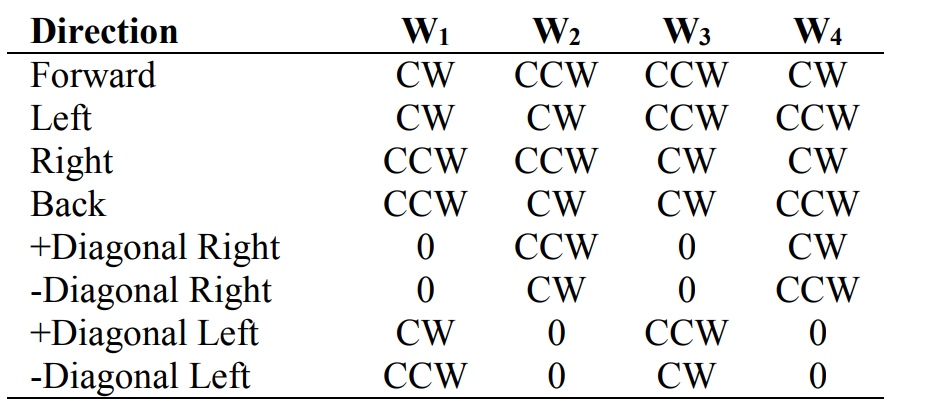

Fig. 2. The robot’s  action over 4 motion of wheels.

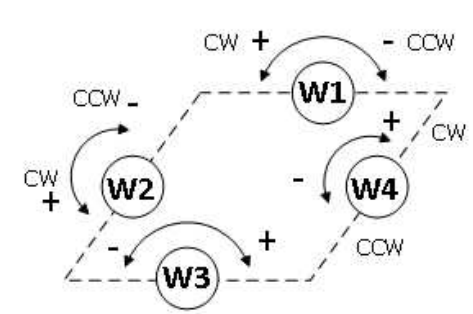

Table 1. Eight directions of the robot’s motion relate to the four wheels’ rotation direction.



## Assumptions:
1. Frictionless Surface
2. 2 D Planar - No Gravity
3. No Spring or damper for the omini wheel.
4. No Friction Considered for the model
5. No Tipping for Omini Model

---

## Constraints
1. y_axis of the robot's position is greater than -1: To avoid Including other way of approach to the desired states. Helped to converge the model.

---

## MPC

The optimization problem can now be formulated as follows:

$$
\begin{aligned}
\min_{(\textbf{x}(t),u(t))} \quad & \quad\quad \|\textbf{x}(T)\|^2 \\
\text{s.t.} \quad & \quad\quad \textbf{x}(t+1) = A\textbf{x}(t) + Bu(t) + c\\
\quad & \quad\quad \textbf{x}(t)[1] \geq -1\\
\quad & \quad\quad |u(t)[0]| \leq 1, |u(t)[1]| \leq 1, u(t)[2]| \leq 1, |u(t)[3]| \leq 1\quad \forall t = 0,...,T-1,
\quad & \quad\quad \textbf{x}(0) = x_0
\end{aligned}
$$
where $B$ is computed based on the current $\theta$. $\textbf{x}(t)[1] \geq -1$ constrains the direction of the model reaching to the final state, $|u(t)[0]| \leq 1, |u(t)[1]| \leq 1, u(t)[2]| \leq 1, |u(t)[3]| \leq 1$ bounds the $\omega_1, \omega_2, \omega_3, \omega_4$, normalized range from -1 to 1.

We solve MPC with ```cvx```. Sample code is as follows:

    def mpc(x_0, T):
        # Define optimization variables
        x = cp.Variable((n_state, T + 1))
        u = cp.Variable((n_action, T))
        theta = x_0[5]

        # Update J_mat (matrix representing the impact of the control inputs on the state)
        B_mat = BOOST_ACCEL * r_wheel/2 * np.array([[-math.sin(theta+math.pi/4), math.sin(theta+3*math.pi/4),math.sin(theta+5*math.pi/4), math.sin(theta+7*math.pi/4)],
                                        [math.cos(theta+math.pi/4), math.cos(theta+3*math.pi/4), math.cos(theta+5*math.pi/4), math.cos(theta+7*math.pi/4)],
                                        [1/(2*R_robot), 1/(2*R_robot), 1/(2*R_robot), 1/(2*R_robot)],
                                        [0., 0., 0., 0.],
                                        [0., 0., 0., 0.],
                                        [0., 0., 0., 0.]])
        
        # Update A_mat (matrix representing the state transition dynamics)
        A_mat = np.array([[1., 0., 0., 0., 0., 0.],
                                    [0., 1., 0., 0., 0., 0.],
                                    [0., 0., 1., 0., 0., 0.],
                                    [FRAME_TIME, 0., 0., 1., 0., 0.],
                                    [0., FRAME_TIME, 0., 0., 1., 0.],
                                    [0., 0., FRAME_TIME, 0., 0., 1.]])

        cost = 0
        constr = []
        for t in range(T):
            constr += [x[:, t + 1] == A_mat @ x[:, t] + B_mat @ u[:, t], 
                    cp.abs(u[:, t]) <= 1,
                    x[4, t] >= -1]
        
        cost = 10 * cp.square(x[3, T]) + cp.sum_squares(x[:, T]) 

        # Concatenate constraints and define the optimization problem
        constr += [x[:, 0] == x_0]
        problem = cp.Problem(cp.Minimize(cost), constr)
        problem.solve()
        return x, u


Since the problem is convex, it can be solved efficiently.

## Real-Time Control with MPC

Since MPC uses a linearized version of the real dynamics, we can only trust its near future planning. Here we will only take the nearest control input solved by MPC to perform one step forward in time. Once we reach the next state, we will solve MPC again by expanding the dynamics at the new state. The code looks like the following:

    def control(x_0, total_time_step):
        x_current = x_0
        for i in range(total_time_step):
            x, u = mpc(x_current, T-i)

            if u[:,0].value is None: # if the MPC problem is infeasible, stop
                print('MPC infeasible.')
                break

            # visualize(np.array(x[1:,:].value).T, np.array(u.value).T)
            action = u[:,0].value
            
            x_current = simulate(x_current, action)
            action_trajectory.append(action)
            state_trajectory.append(x_current)

Here ```total_time_step``` defines the whole control time window, ```T``` defines the look-ahead time window used to define and solve MPCs. As we progress in time (through the ```for``` loop), the look-ahead time window for MPC reduces so that the solver knows that the objectives should be achieved within a decreasing amount of time.

In [1]:
!pip install cvxpy==1.4.1

In [2]:
!pip install cvxpylayers==0.1.6

In [3]:
import cvxpy as cp
import torch
from cvxpylayers.torch import CvxpyLayer
import numpy as np
import math
import matplotlib.pyplot as plt


# Constants for the robot and simulation
r_wheel = 0.1 # r - Radius of the wheel
R_robot = 0.7 # R - Radius of the robot

n_state = 6
n_action = 4
T = 200
dt = 0.02
x_0 = np.array([0., 0., 0., 4., 3.,0.])  # Initial state of the robot
fs = torch.tensor([[0.,0.,0.,0.,0.,-3.14]]) # Final state for the simulation

total_time_step = 200


action_trajectory = [] 
state_trajectory = []

# Environment parameters
FRAME_TIME = 0.1  # time interval
BOOST_ACCEL = 0.18  # thrust constant
OMEGA_RATE = 0.1  # max rotation rate 


def mpc(x_0, T):
    """
    Model Predictive Control (MPC) function for optimizing the robot's trajectory.

    Args:
        x_0 (np.array): Initial state of the robot.
        T (int): Time horizon.

    Returns:
        tuple: Optimized state and control trajectories.
    """

    # Define optimization variables
    x = cp.Variable((n_state, T + 1))
    u = cp.Variable((n_action, T))
    theta = x_0[5]

    # Update J_mat (matrix representing the impact of the control inputs on the state)
    B_mat = BOOST_ACCEL * r_wheel/2 * np.array([[-math.sin(theta+math.pi/4), math.sin(theta+3*math.pi/4),math.sin(theta+5*math.pi/4), math.sin(theta+7*math.pi/4)],
                                    [math.cos(theta+math.pi/4), math.cos(theta+3*math.pi/4), math.cos(theta+5*math.pi/4), math.cos(theta+7*math.pi/4)],
                                    [1/(2*R_robot), 1/(2*R_robot), 1/(2*R_robot), 1/(2*R_robot)],
                                    [0., 0., 0., 0.],
                                    [0., 0., 0., 0.],
                                    [0., 0., 0., 0.]])
    
    # Update A_mat (matrix representing the state transition dynamics)
    A_mat = np.array([[1., 0., 0., 0., 0., 0.],
                                [0., 1., 0., 0., 0., 0.],
                                [0., 0., 1., 0., 0., 0.],
                                [FRAME_TIME, 0., 0., 1., 0., 0.],
                                [0., FRAME_TIME, 0., 0., 1., 0.],
                                [0., 0., FRAME_TIME, 0., 0., 1.]])

    cost = 0
    constr = []
    for t in range(T):
        constr += [x[:, t + 1] == A_mat @ x[:, t] + B_mat @ u[:, t], 
                   cp.abs(u[:, t]) <= 1,
                   x[4, t] >= -1]
    
    cost = 10 * cp.square(x[3, T]) + cp.sum_squares(x[:, T]) 

    # Concatenate constraints and define the optimization problem
    constr += [x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve()
    return x, u

def visualize(x,u):
    """
    Visualize the results of the MPC optimization.

    Args:
        x (np.array): State trajectory.
        u (np.array): Control input trajectory.

    Returns:
        None
    """
    data = x
    action_data = u
    x = data[:, 3]
    y = data[:, 4]
    vx = data[:, 0]
    vy = data[:, 1]
    theta = data[:, 5]
    w1 = action_data[:,0]
    w2 = action_data[:,1]
    w3 = action_data[:,2]
    w4 = action_data[:,3]

    frame = range(T)
    
    fig, ax = plt.subplots(2, 3, tight_layout = 1, figsize = (15, 7))

    ax[0, 0].plot(x, y, c = 'b')
    ax[0, 0].set_xlabel("X")
    ax[0, 0].set_ylabel("Y")
    ax[0, 0].set(title=f'Displacement plot(x-y)')

    ax[1, 0].plot(frame, vx, c = 'c', label = "Velocity in x")
    ax[1, 0].plot(frame, vy, c = 'r', label = "Velocity in y")
    ax[1, 0].set_xlabel("Time")
    ax[1, 0].set_ylabel("Velocity (m/s)")
    ax[1, 0].legend(frameon=0)
    ax[1, 0].set(title =f'Velocity plot')
    
    ax[0, 1].plot(frame, w1, c = 'g', label = "theta")
    ax[0, 1].set_xlabel("Time interval")
    ax[0, 1].set_ylabel("w1")
    ax[0, 1].legend(frameon=0)
    ax[0, 1].set(title=f'w1 plot')

    ax[0, 2].plot(frame, w2, c = 'g', label = "theta")
    ax[0, 2].set_xlabel("Time interval")
    ax[0, 2].set_ylabel("w2")
    ax[0, 2].legend(frameon=0)
    ax[0, 2].set(title=f'w2 plot')

    ax[1, 1].plot(frame, w3, c = 'y', label = "thrust")
    ax[1, 1].set_xlabel("Time interval")
    ax[1, 1].set_ylabel("w3")
    ax[1, 1].legend(frameon=0)
    ax[1, 1].set(title=f'w3 plot')

    ax[1, 2].plot(frame, w4, c = 'y', label = "thrust")
    ax[1, 2].set_xlabel("Time interval")
    ax[1, 2].set_ylabel("w4")
    ax[1, 2].legend(frameon=0)
    ax[1, 2].set(title=f'w4 plot')

    plt.show()

def simulate(state, action):
    """
    Simulate the robot dynamics based on the current state and action.

    Args:
        state (np.array): Current state of the robot.
        action (np.array): Control input.

    Returns:
        np.array: Updated state after simulating the dynamics.
    """
    n = abs(int(state[5]/(2*math.pi)))
    theta = state[5] - n *2* math.pi

    # Update J_mat
    J_mat = BOOST_ACCEL * r_wheel/2 * np.array([[-math.sin(theta+math.pi/4), math.sin(theta+3*math.pi/4),math.sin(theta+5*math.pi/4), math.sin(theta+7*math.pi/4)],
                                    [math.cos(theta+math.pi/4), math.cos(theta+3*math.pi/4), math.cos(theta+5*math.pi/4), math.cos(theta+7*math.pi/4)],
                                    [1/(2*R_robot), 1/(2*R_robot), 1/(2*R_robot), 1/(2*R_robot)],
                                    [0., 0., 0., 0.],
                                    [0., 0., 0., 0.],
                                    [0., 0., 0., 0.]])
    
    shift_mat = np.array([[1., 0., 0., 0., 0., 0.],
                                [0., 1., 0., 0., 0., 0.],
                                [0., 0., 1., 0., 0., 0.],
                                [FRAME_TIME, 0., 0., 1., 0., 0.],
                                [0., FRAME_TIME, 0., 0., 1., 0.],
                                [0., 0., FRAME_TIME, 0., 0., 1.]])

    
    state = shift_mat @ state + J_mat @ action 

    print(state)
    print(action)
    return state

def control(x_0, total_time_step):
    """
    Perform MPC-based control for a given number of time steps.

    Args:
        x_0 (np.array): Initial state of the robot.
        total_time_step (int): Number of time steps to simulate.

    Returns:
        None
    """

    x_current = x_0
    for i in range(total_time_step):
        x, u = mpc(x_current, T-i)

        if u[:,0].value is None: # if the MPC problem is infeasible, stop
            print('MPC infeasible.')
            break

        # visualize(np.array(x[1:,:].value).T, np.array(u.value).T)
        action = u[:,0].value
        
        x_current = simulate(x_current, action)
        action_trajectory.append(action)
        state_trajectory.append(x_current)

control(x_0, total_time_step)


[ 2.04896070e-03 -5.68072068e-03 -6.52696533e-04  4.00000000e+00
  3.00000000e+00  0.00000000e+00]
[-0.24854243  0.11021627  0.28533801 -0.24854243]
[ 3.25986238e-03 -1.06093490e-02 -2.70634673e-03  4.00020490e+00
  2.99943193e+00 -6.52696533e-05]
[-0.27347898 -0.06459093  0.29209219 -0.27347898]
[ 2.38650523e-03 -1.38285231e-02 -2.83989447e-03  4.00053088e+00
  2.99837099e+00 -3.35904326e-04]
[-0.13223917 -0.07901234  0.32153439 -0.13105697]
[ 2.51951514e-03 -1.92339286e-02 -2.14815790e-03  4.00076953e+00
  2.99698814e+00 -6.19893774e-04]
[-0.18869706  0.06417273  0.41425789 -0.1821301 ]
[ 1.80313107e-03 -2.42630763e-02 -1.24619970e-03  4.00102148e+00
  2.99506475e+00 -8.34709564e-04]
[-0.1686879   0.01372756  0.45141243 -0.15614748]
[ 1.23487382e-03 -2.91610372e-02 -4.06925961e-04  4.00120180e+00
  2.99263844e+00 -9.59329533e-04]
[-0.16825814  0.02044971  0.42946956 -0.15110744]
[ 8.97426884e-04 -3.29658814e-02 -1.11025872e-03  4.00132528e+00
  2.98972234e+00 -1.00002213e-03]
[-0.190

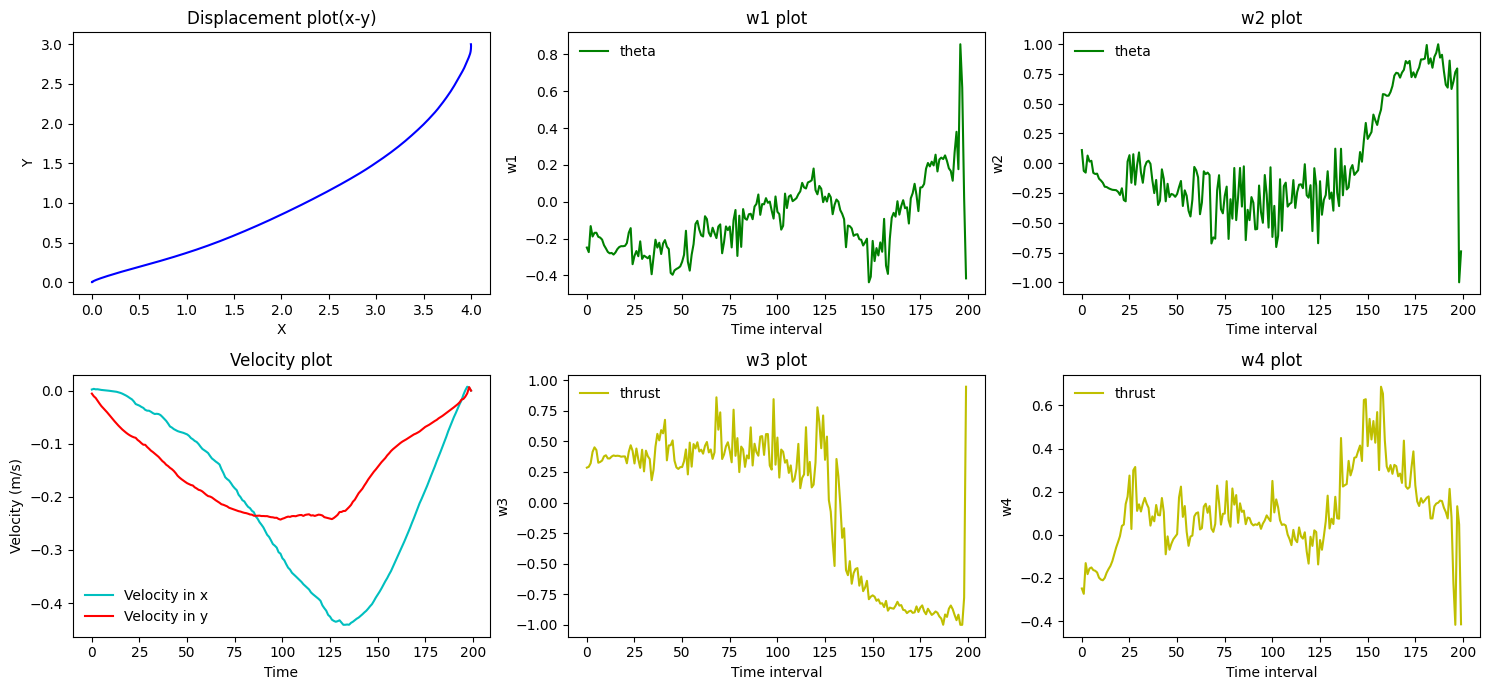

In [4]:
import matplotlib.pyplot as plt
# Visualize the results of the MPC optimization.
visualize(np.array(state_trajectory), np.array(action_trajectory))

In [5]:
!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml') 

Generating Animation


IntProgress(value=0, max=200)

(200, 6) (200, 4)


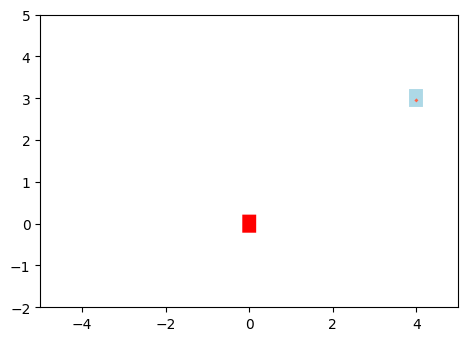

In [6]:
def animation(state_trajectory, action_trajectory):
        """
        Generate an animation of the robot's movement based on state and action trajectories.

        Args:
            state_trajectory (np.array): Array containing the state trajectory of the robot.
            action_trajectory (np.array): Array containing the action (control input) trajectory.

        Returns:
            None
        """

        length = 0.05          # m
        width = 0.02          # m

        v_exhaust = 1     
        print("Generating Animation")
        steps = T
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array(state_trajectory)
        action_data = np.array(action_trajectory)
        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)

        ln1, = ax1.plot([], [], linewidth = 10, color = 'lightblue') # rocket body
        ln6, = ax1.plot([], [], '--', linewidth = 1, color = 'orange') # trajectory line
        ln2, = ax1.plot([], [], linewidth = 2, color = 'tomato') # thrust line

        ln7, = ax1.plot([], [], linewidth = 10, color = 'red') # Desired robot body

        rocket_theta = fs[0, 5]
        rocket_x = fs[0, 3]
        # length/1 is just to make rocket bigger in animation
        rocket_x_points = [rocket_x + length/1 * np.sin(rocket_theta), rocket_x - length/1 * np.sin(rocket_theta)]
        
        rocket_y = fs[0, 4]
        
        rocket_y_points = [rocket_y + length/1 * np.cos(rocket_theta), rocket_y - length/1 * np.cos(rocket_theta)]
        
        ln7.set_data(rocket_x_points, rocket_y_points)

        plt.tight_layout()

        ax1.set_xlim(-5, 5)
        ax1.set_ylim(-2, 5)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):
            rocket_theta = x_t[i, 5]

            rocket_x = x_t[i, 3]
            # length/1 is just to make rocket bigger in animation
            rocket_x_points = [rocket_x + length/1 * np.sin(rocket_theta), rocket_x - length/1 * np.sin(rocket_theta)]

            rocket_y = x_t[i, 4]
            rocket_y_points = [rocket_y + length/1 * np.cos(rocket_theta), rocket_y - length/1 * np.cos(rocket_theta)]

            ln1.set_data(rocket_x_points, rocket_y_points)

            vel_length_v_x = x_t[i, 0]
            vel_length_v_y = x_t[i, 1]
            velocity_theta = math.atan(x_t[i,1]/x_t[i,0])

            vel_x_points = [rocket_x_points[1], rocket_x_points[1] + vel_length_v_x * np.sin(velocity_theta)]
            vel_y_points = [rocket_y_points[1], rocket_y_points[1] + vel_length_v_y * np.cos(velocity_theta)]

            ln2.set_data(vel_x_points, vel_y_points) # Velocity Vector

            ln6.set_data(x_t[:i, 3], x_t[:i, 4])
            f.value += 1

        playback_speed = 5000 # the higher the slower 
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("OminiMovement_MPC.gif", writer=writer)

# Assuming state_trajectory and action_trajectory are already defined
animation(state_trajectory, action_trajectory)

# Breakdown of Visualization
Orange colored Vector --> Velocity vector of the robot. 

Red colored Robot Body --> Desired/ Final Robot's state

Blue colored Robot Body --> Dynamically moving Robot Body from the initial state towards the final State


## 4. Grading

* (20%) **Documentation of the problem formulation**: Clearly describe the objective function, the variables, the constraints (including the dynamical systems involved), and the assumptions involved in formulating the problem.

* (30%) **Programming**: Please push you code to your github repo or a deepnote notebook. Please comment your code so that it is useful to you in the future.

* (30%) **Analysis of the results**: Please explain clearly and in details all issues you encountered and lessons you learned in solving your problem, including incorrect problem formulations, hyperparameter tuning (e.g., for the optimization algorithm), and coding issues (e.g., related to tensor operations).

* (20%) **Visualization**: Once you find a converged solution, please do your best to visualize the final results in video and other necessary formats so that other people can easily understand what you achieved. 

# Analysis of Results

Here we set up the dynamical model in PyTorch. The dynamics is written as the forward pass of a neural network (`nn.Module`) so that it becomes a part of a differentiable computational graph. Note: This is the part that requires a lot of patience and care!

### Explanation:

- `action_tensor` is $[\omega_{1}(t), \omega_{2}(t),\omega_{3}(t),\omega_{4}(t)]$
- `x(t)` is $[\dot{x}(t), \dot{y}(t), \dot{\theta}(t), x(t), y(t), \theta(t)]$
- the state of $t+1$ is denoted by `state` and its elements are updated by the matrix multiplication of a shift matrix and a control matrix:

$$
\textbf{x}(t+1) = \left[\begin{array}{llll}
1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0\\
\Delta t & 0 & 0 & 1 & 0 & 0\\
0 & \Delta t & 0 & 0 & 1 & 0\\
0 & 0 & \Delta t & 0 & 0 & 1\\ 
\end{array}\right]\textbf{x}(t) + \frac{rwheel}{2} \times \left[\begin{array}{llll}
-\sin(\theta+\pi/4) & -\sin(\theta+3\pi/4 & -\sin(\theta+5\pi/4) & -\sin(\theta+7\pi/4) \\
\cos(\theta+\pi/4) & \cos(\theta+3\pi/4 & \cos(\theta+5\pi/4) & \cos(\theta+7\pi/4) \\
1/(2*rRobot) & 1/(2*rRobot) & 1/(2*rRobot) & 1/(2*rRobot) \\
0 & 0 & 0 & 0  \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 
\end{array}\right] \times \text{action tensor}
$$

The above implementation may seem quite elaborate, but it is necessary because, to build a differentiable graph, PyTorch does not allow direct editing of individual tensor elements.

---

### Issues and Lessons Learned

#### 1. Handling Inequality Constraints
   - **Issue:** Dealing with inequality constraints in the MPC formulation.
   - **Lesson Learned:** Ensure that the inequality constraints are correctly formulated. In your case, $\textbf{x}(t)[1] \geq -1$ constrains the second component of the state vector, and $|u(t)[i]| \leq 1$ constrains each component of the control input vector.

#### 2. Scaling of Cost Function and Constraints:
   - **Issue:** Properly scale the cost function and constraints to achieve a balance between optimizing the performance objective and satisfying the constraints.
   - **Lesson Learned:** The coefficient 10 in front of cp.square(x[3, T]) suggests a higher penalty on the fourth state variable. Adjust these coefficients based on the relative importance of the terms in your specific application.

#### 3. Initial Conditions:
   - **Issue:** The choice of initial conditions (x_0) can significantly impact the MPC's performance. 
   - **Lesson Learned:** Ensure that the initial conditions are feasible and representative of the system's typical operating conditions.

#### 4. Impact of Constraint Violation:
   - **Issue:** Understand the impact of constraint violation on the system behavior. For example, violating $\textbf{x}(t)[1] \geq -1$ may lead to undesired states.  
   - **Lesson Learned:** By Adjusting the weights or penalties associated with these constraints to guide the optimization towards feasible solutions.

   - **Issue:** Infeasibility, If the initial conditions or the dynamics of the system push $\textbf{x}(t)[1]$ below -1, the optimization problem becomes infeasible. 
   - **Lesson Learned:** Double Check for the result in the solver being unable to find a valid solution.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59115d46-a419-43f9-a3fe-b160aca2a335' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>